<a href="https://colab.research.google.com/github/pnorridge/think-global-act-local/blob/master/MNIST_%26_SNR_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Think Global, Act Local: MNIST

This notebook is a supplement to the paper *Think Global, Act Local: The relationship between DNN generalisation and node-level information preservation.*

Abstract: The reasons behind good DNN generalisation remain an open question. In this paper we explore the problem by looking at the Signal-to-Noise Ratio of nodes in the network. Starting from information theory principles, it is possible to derive an expression for the SNR of a DNN node output. Using this expression we construct figures-of-merit that quantify how well the weights of a node optimise SNR (or, equivalently, information rate). Applying these figures-of-merit, we give examples indicating that weight sets that promote good SNR performance also exhibit good generalisation.

This notebook gives an example of the process applied to MNIST classification. It includes examples of plots not included in the paper: evolution of the figures-of-merit over time and scatter plots of $w_{ij}$ vs. $c_i$. 

(Note: It is designed for clarity not performance and includes some functions sized against the memory constraints of Colab GPUs.)

The underlying reasoning for considering node-level SNR and SNR-optimising weights can be summarised as:

* A DNN will perform best when the available information is used to maximum extent.

* Optimal use of information by the entire network depends on maximising the information preservation of individual nodes.

* With some assumptions, it is possible to derive a relationship between the output SNR of a node and the maximisation of the information preservation from inputs to output (characterised by the mutual information or the information rate at the output of the node). So, if we want to optimise the information flow in the network, we should pay attention to the SNR of the individual nodes.

* It is possible to quantify how well a given set of weights optimises the SNR within the context of a given network and training set. Even though we cannot define a priori the signal that a node should generate, we can construct formulae that allow the SNR quality of a post-training weight set to be assessed. 

# Admin

Import packages and test data. Plus define some basic functions that will be useful.

In [0]:
# Admin
%tensorflow_version 1.x
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [3]:
# Load in the test data & configure an iterator
train_data, test_data = tfds.load("mnist", split=[tfds.Split.TRAIN, tfds.Split.TEST])
#train_data, test_data = data['train'], data['test']

def data_preprocess(record):
  img = tf.image.convert_image_dtype(record['image'],tf.float32)
  lab = tf.cast(record['label'],tf.int32)
  return dict(image = img, label = lab)

train_data = train_data.map(data_preprocess)
test_data = test_data.map(data_preprocess)

batched_data = train_data.shuffle(buffer_size=60000).batch(60).repeat(1000).prefetch(10)
data_iterator = iter(batched_data)

# For this example, we want to use all the test data for the SNR calculations. 
# A large data set ensures that the covariances are representative.
all_test_data = iter(test_data.batch(10000)).get_next()


# Set up a zero vector -- used as reference points when doing correlations
x_zero = tf.zeros([10,28,28])
test_images = all_test_data['image']
test_labels = all_test_data['label']


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
# Essential model-independent helper functions
def weight_variable(shape):
  initial = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
  return initial

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
    
def measure_accuracy(labels, logits):
  correct_prediction = tf.equal(tf.cast(labels, tf.int64), tf.argmax(logits, axis=1))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def cross_entropy(x, y):
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x))

# Layer function generators. 
# Note that we split the layers into the weight multiplcation and the 
# offset+relu parts. This is convenient for the SNR calculations.

def dot_layer(f, wts):  
  def layer(x,p): 
    return tf.matmul(f(x,p),wts)
  
  return layer

def relu_layer(f, bs):
  def layer(x,p):
    return tf.nn.dropout(tf.nn.relu(f(x,p)+bs),p)
  
  return layer

# Mean calculation with removal of NaN terms, if any.
def masked_mean(measure, weight = None):
  if weight is None:
    weight = tf.ones(measure.shape)
  
  mean = tf.reduce_mean(tf.boolean_mask(measure,tf.logical_not(tf.is_nan(measure))))
  return mean

# Building blocks for figures-of-merit

We start by defining a modified covariance function. This calculates the covariance between a node input and the output -- and scales by the non-zero rate of the input.

\begin{equation}
 c_{i}= \frac{\text{cov} \left( x_i,\sum w_{ij} x_j\right)}{a_i} = \frac{\text{cov} \left( x_i,r_i\right)}{a_i} 
\end{equation}

$ a_i = p(x_i > 0) $


In [0]:
def relu_covariance_batch(x,r):
  # This calculates the covariance, including the scaling factor appropriate for ReLU-like inputs.
  # Implemented with batching due to memory issues with large inputs.

  batch_sz = 50
  
  leng = tf.cast(x.shape[0],tf.float32)

  m = int(leng/batch_sz-1)

  # Normalise the inputs. This is a quick and dirty way to get the noise variances to approximately the same magnitude.
  max_count = tf.cast(x.shape[0], tf.float32)
  x = x/(tf.reduce_max(x, axis = 0)+0.001)
  
  xx = tf.cast(tf.expand_dims(x,-1),tf.float32)
  rr = tf.expand_dims(r,1)
  
  # Shift inputs to be zero mean
  xxm = tf.reduce_sum(xx[batch_sz*m:], axis = 0)
  rrm = tf.reduce_sum(rr[batch_sz*m:], axis = 0)
  for k in range(0,m):
    xxm = xxm + tf.reduce_sum(xx[batch_sz*k:batch_sz*(k+1)], axis = 0)
    rrm = rrm + tf.reduce_sum(rr[batch_sz*k:batch_sz*(k+1)], axis = 0)
  
  rr = rr - rrm/tf.cast(rr.shape[0],tf.float32)
  # Calculate the variance
  xr = tf.reduce_sum(xx[batch_sz*m:,:,:]*rr[batch_sz*m:,:,:], axis = 0)
  for k in range(0,m):
    xr = xr + tf.reduce_sum(xx[batch_sz*k:batch_sz*(k+1),:,:]*rr[batch_sz*k:batch_sz*(k+1),:,:], axis = 0)


  # Scaling for ReLU inputs 
  x_count = tf.reduce_sum(tf.cast(xx>0, tf.float32), axis = 0) 
  xr = xr/(x_count+0.0001) # lazily ensure no 1/0

  return xr


# SNR Optimality 

To derive the SNR Optimiality expression, we start with the usual (signal processing) definition of SNR applied to node $i$ in layer $m$

\begin{equation}
SNR_i^{(m)} =\frac{\text{var} \left(\sum_{j}w_{ij}s_{j} \right)}{ \sum_{j}w_{ij}^2\text{var} \left( n_{j} \right) } 
\end{equation}

where $s_j$ are the signal and $n_j$ are the noise components. We find weights that maximise the expression.  

\begin{equation}
w_{ij}= k_i .  \frac{\text{cov} \left( s_j, \sum w_{ij} s_i \right) }{\text{var} \left( n_j \right)}  
\end{equation}


To allow us to use this, we make two pragmatic assumptions. 
The first is that the after training, the signal dominates the node output, so that 
\begin{equation}
\text{cov} \left( s_i, \sum w_{ij} s_j \right) \approx \text{cov} \left( x_j, \sum w_{ij} x_i \right)
\end{equation}

The second is that the noise has identical variance for each non-zero input sample and zero variance otherwise. So,
\begin{equation}
 \text{var} \left( n_{j} \right) \approx a_j ~ \text{var}(n)
\end{equation}

where $\text{var}(n)$ is the noise variance of all non-zero samples arriving at node $i$ and $a_i$ is the rate of activations of node $j$ of layer $(m-1)$. 

Using these assumptions, we update the expression for optimal weights to
\begin{equation}
w_{ij} = k_i' .  \frac{\text{cov} \left( x_i, \sum w_{ij} x_j \right) }{ a_j }  
\end{equation}


We do not expect that nodes will generally meet this condition, but we would like to assess how close a given weight configuration is to 'optimal'. We can measure this by treating $w_{ij}$ and $\frac{\text{cov} \left( x_i, \sum w_{ij} x_j \right) }{\left( a_j \right)}$ as vectors and calculating the inner product between them.

\begin{equation}
S_i =\frac{ \sum _{j}w_{ij}c_{j}}{ \| \vec{w_{i}} \|  \| \vec{c} \| } 
\end{equation}

where $\vec{c}$ is as defined above.

In [0]:

def SNROptimality_batch(x, r, W):
  
    xR = relu_covariance_batch(x,r)
    
    nm = (tf.norm(xR,axis=0)+0.0001)
    c_hat = xR/nm

    
    count = tf.reduce_sum(tf.cast(c_hat*W<0, tf.float32))
    numer = tf.reduce_sum(c_hat*W, axis = 0)
  
    norm_wtv = tf.norm(W, axis=0)

    denom = norm_wtv

    return (numer/denom, count)
  


The following will be used later to aid with visualisation of the SNR optimality. It generates plots of $w_{ij}$ against $c_i$

In [0]:
def Optimality_Plot(x, r, W, node_list):
  
    xR = relu_covariance_batch(x,r)
        
    W1 = W[:,node_list]
 
    c_hat = xR/(tf.norm(xR, axis=0))

    norm_wtv = tf.norm(W1, axis=0)

    normed_wt = W1/norm_wtv

    fig,ax = plt.subplots(figsize=(5,5))

    ax.plot(normed_wt,c_hat[:,node_list],'.')
    ax.fill_between([0, tf.reduce_max(normed_wt).numpy()*1.1], 0,tf.reduce_max(c_hat[:,node_list]).numpy()*1.1,alpha=0.2, color='#1F98D0')  
    ax.fill_between([tf.reduce_min(normed_wt).numpy()*1.1, 0], tf.reduce_min(c_hat[:,node_list]).numpy()*1.1, 0, alpha=0.2, color='#1F98D0')  

    return ax

# SNR Gain
To measure SNR improvement, we compare the SNR Optimiality for a given weight vector with the case where we simply selected the most representative input and passed that through transparently. That is, we calculating $S_i$ using only the input that is best correlated with the output of the node. We fix $c_j$ and then use $w_{ij}'$ defined by
\begin{equation}
    w_{ij}' =  \begin{cases}
                1 \ \ \  \text{if }  j=\text{argmax}_k \left( c_k \right)   \\
               0 \ \ \  \text{otherwise}
            \end{cases}
\end{equation}

For this choice,
\begin{equation} 
S_i' = \frac{ \sum _{j}^{}w_{ij}'c_{j}}{ \| \vec{w'_i} \|  \| \vec{c} \| }  =  \frac{\max_{i} \left( c_{i} \right) }{ \| \vec{c} \| } 
\end{equation}

The ratio of the $S_i$ and $S_i'$ becomes
\begin{equation}
F=\frac{ \sum _{j}^{}w_{ij}c_{j}}{ \| \vec{w_i} \| \max_{i} \left( c_{i} \right) } 
\end{equation}


In [0]:
def SNRGain_batch(x, r, W):
  
    xR = relu_covariance_batch(x,r)
    
    nm = (tf.reduce_max(tf.abs(xR),axis=0,keepdims=True))
    c_hat = xR/nm

    
    count = tf.reduce_sum(tf.cast(c_hat*W<0, tf.float32))
    numer = tf.reduce_sum(c_hat*W, axis = 0)
  
    norm_wtv = tf.norm(W, axis=0)

    denom = norm_wtv

    return (numer/denom, count)
  

# Model definition


## Base class
Define our base class. The construction is relatively low-level to allow easy access to all the information needed for the figures-of-merit.

Includes weights, plus methods for classifification and SNR figures-of-merit.

In [0]:

class trainable_function:

  def __init__(self, withWeightsFrom = None):
    self.W = []
    self.b = []

    node_list = [784, 1024, 1000, 10]

    # Set up the weights
    if withWeightsFrom == None:
      for last_n, nodes in zip(node_list[:-1], node_list[1:]):
        self.W.append(weight_variable([last_n, nodes]))
        self.b.append(bias_variable([nodes]))
    
    else:
      self.W = [tf.Variable(k) for k in withWeightsFrom.W]
      self.b = [tf.Variable(k) for k in withWeightsFrom.b]

    # record the trainable variables
    self.variables = [k for k in self.W] + [k for k in self.b]

    # Build the network
    self.layer_dot = [lambda x, p: x]
    self.layer_relu = [lambda x, p: tf.reshape(x,[-1,784])]
    
    for kk in range(1,len(self.W)):
      self.layer_dot.append(dot_layer(self.layer_relu[kk-1], self.W[kk-1])) 
      self.layer_relu.append(relu_layer(self.layer_dot[kk], self.b[kk-1]))

    self.layer_dot.append(dot_layer(self.layer_relu[-1], self.W[-1])) 

    self.optimiser = tf.train.GradientDescentOptimizer(0.1)

    
  ##
  # Required interfaces for the class
  def classify(self, x, p = 1.):
    return self.layer_dot[-1](x,p)

  def train(self, x, y):
    None


  ##
  # SNR instrumentation

  # Calculate F for one layer
  def SNRGain(self, x, layer):
    x_int = self.layer_relu[layer-1](x,1.)
    r = tf.matmul(x_int, self.W[layer-1]) 
    return SNRGain_batch(x_int, r, self.W[layer-1])


  # Calculate mean(F) for each layer
  def SG_summary(self, x):
    res = []
    for k in range(len(self.layer_relu)):
      (measure, count)  = self.SNRGain(x, k+1)
      res.append(masked_mean(measure))
    return res


  # Calculate S for one layer
  def SNROptimality(self, x, layer):
    x_int = self.layer_relu[layer-1](x,1.)
    r = tf.matmul(x_int, self.W[layer-1]) 
    return SNROptimality_batch(x_int, r, self.W[layer-1])
  
  # Calculate mean(S) for each layer
  def SNR_summary(self, x):
    res = []
    for k in range(len(self.layer_relu)):
      (measure, count)  = self.SNROptimality(x, k+1)
      res.append(masked_mean(measure))
    return res


  # Plot w against c for set of nodes
  def Optimality_plot(self, x, layer, nodes):
    x_int = self.layer_relu[layer-1](x,1.)
    r = tf.matmul(x_int, self.W[layer-1]) 
    return Optimality_Plot(x_int, r, self.W[layer-1], nodes)



## Sub-classes 

Sub-classes representing different training methods/regularisation.

In [0]:
##
# Basic SGD with no regulsatisation
class trainable_function_with_noreg(trainable_function):

  def calc_grad(self, inputs, targets):
    with tf.GradientTape() as tape:
      loss_value = cross_entropy(self.classify(inputs, p = 1.), targets)
    return tape.gradient(loss_value, self.variables)

  def train(self, x,y):
    grads = self.calc_grad(x, y)
    self.optimiser.apply_gradients(zip(grads, self.variables))

##
# Basic SGD with dropout
class trainable_function_with_dropout(trainable_function):

  def calc_grad(self, inputs, targets):
    with tf.GradientTape() as tape:
      loss_value = cross_entropy(self.classify(inputs, p = 0.5), targets)
    return tape.gradient(loss_value, self.variables)

  def train(self, x,y):
    grads = self.calc_grad(x, y)
    self.optimiser.apply_gradients(zip(grads, self.variables))
    
##
# Basic SGD with L2 regulsatisation
class trainable_function_with_L2(trainable_function):

  def calc_grad(self, inputs, targets):
    with tf.GradientTape() as tape:
      loss_value = cross_entropy(self.classify(inputs, p = 1.), targets) \
                                 +0.00005*(tf.nn.l2_loss(self.W[0])\
                                 +tf.nn.l2_loss(self.W[1])\
                                 +tf.nn.l2_loss(self.W[2]))
                                 
    return tape.gradient(loss_value, self.variables)

  def train(self, x,y):
    grads = self.calc_grad(x, y)
    self.optimiser.apply_gradients(zip(grads, self.variables))



# Training & evaluation

Set up three models for comparison. We use identical starting weights and training data to ensure that we are comparing between training methods, not simply the initialisation and data.


In [0]:
control = trainable_function()
model_n = trainable_function_with_noreg(control)
model_l2 = trainable_function_with_L2(control)
model_d = trainable_function_with_dropout(control)

model_list = [model_n, model_l2, model_d]

test_acc = {lst: [] for lst in model_list} 
SNR = {lst: [] for lst in model_list} 
SG = {lst: [] for lst in model_list} 


Training with regular calculations of the figures-of-merit. A good time for a coffee.




In [12]:
# Main loop
for i in range(100001):
  
  dat = data_iterator.get_next()

  # Loop over models
  for model in model_list:

      # Instrumentation

      if i % 200 == 0:
        test_accuracy  = measure_accuracy(labels = test_labels, logits = model.classify(test_images))
        test_acc[model].append(test_accuracy)


      if i % 2000 == 0:
        SG[model].append(model.SG_summary(test_images))
        SNR[model].append(model.SNR_summary(test_images))
        

      if i % 10000 == 0:
        print('\n Step %d' % i)
        print(type(model).__name__)
        print('Test accuracy %g' % test_accuracy)
        print('L1: %g' % SNR[model][-1][0])
        print('L2: %g' % SNR[model][-1][1])
        print('L3: %g' % SNR[model][-1][2])


      # Actual training          
      model.train(dat['image'], dat['label'])

  if i % 20000 == 0:
    print('------\n')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



 Step 0
trainable_function_with_noreg
Test accuracy 0.1027
L1: 0.146859
L2: 0.176193
L3: 0.13557

 Step 0
trainable_function_with_L2
Test accuracy 0.1027
L1: 0.146859
L2: 0.176193
L3: 0.13557

 Step 0
trainable_function_with_dropout
Test accuracy 0.1027
L1: 0.146859
L2: 0.176193
L3: 0.13557
------


 Step 10000
trainable_function_with_noreg
Test accuracy 0.9809
L1: 0.148669
L2: 0.169672
L3: 0.382087

 Step 10000
trainable_function_with_L2
Test accuracy 0.9814
L1: 0.14882
L2: 0.168961
L3: 0.386648

 Step 10000
trainable_function_with_dropout
Test accuracy 0.9784
L1: 0.158319
L2: 0.213317
L3: 0.658947


# Results

## Test accuracy for each model 

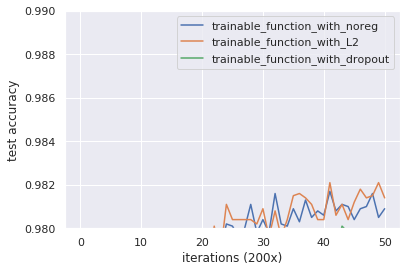

In [13]:
for m in model_list:
  plt.plot(test_acc[m])
plt.ylim([0.98,0.99])
plt.ylabel('test accuracy')
plt.xlabel('iterations (200x)')
plt.legend([type(model).__name__ for model in model_list])

## SNR optimality

Note that the SNR optimality is correlated with performance after convergence. Interestingly, for dropout the SNR optimality indicates the enhanced performance before this is seen in the test accuracy results.

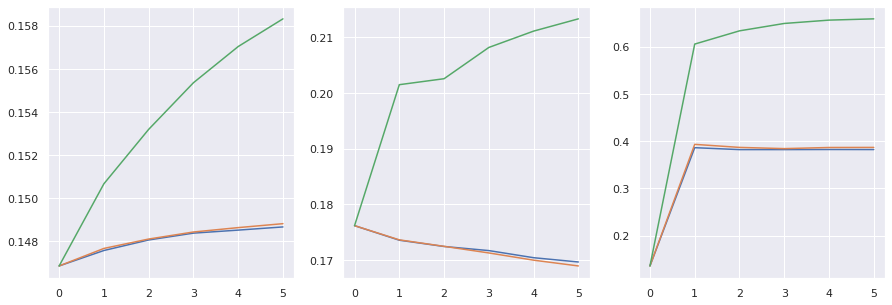

In [14]:
fig, a = plt.subplots(1,3,figsize=(15, 5))
for m in model_list:
  a[0].plot([a[0] for a in SNR[m]])
  a[1].plot([a[1] for a in SNR[m]])
  a[2].plot([a[2] for a in SNR[m]])

Note that for dropout $S$ increases before the test accuracy, giving an early indication of better perfromance. 
See paper for (brief) discussion of long-term $l_2$ behaviour.  

## SNR Gain

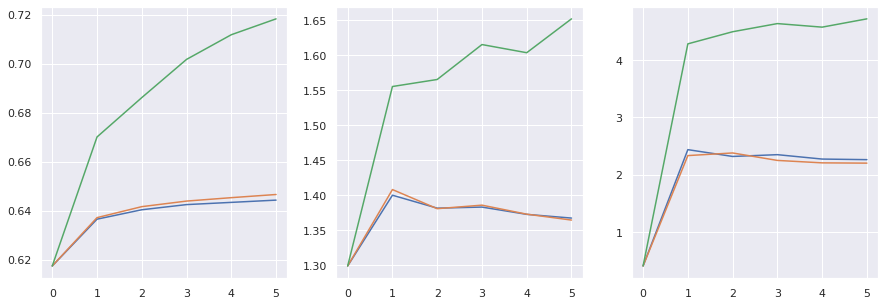

In [15]:
fig, a = plt.subplots(1,3,figsize=(15, 5))
for m in model_list:
  a[0].plot([a[0] for a in SG[m]])
  a[1].plot([a[1] for a in SG[m]])
  a[2].plot([a[2] for a in SG[m]])

## Scatter plots of $w$ vs. $c$

Here, we plot $w$ against $c$ for one node. This gives a more intuitive & visual sense of what it means to have good SNR optimality. The points become increasingly close to the line $w=c$ as they approach a more SNR-optimal configuration.

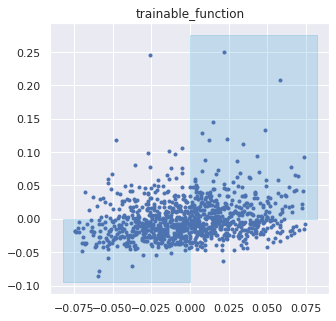

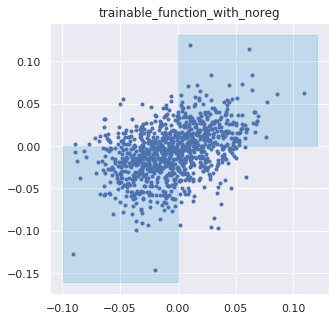

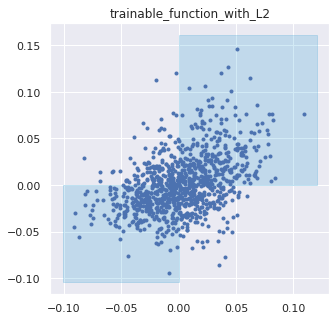

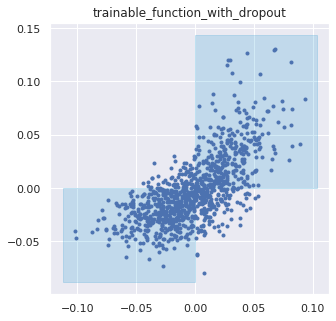

In [16]:
for m in [control]+model_list:
  ind = tf.argmax(m.SNROptimality(test_images,3)[0])
  ax = m.Optimality_plot(test_images,3,ind)
  ax.set_title(type(m).__name__)
  plt.show()